In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os
import admix
from os.path import join
import itertools
import admix_genet_cor
import submitit
import glob
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string
from natsort import natsorted

In [2]:
df_params = pd.DataFrame(
    [
        params
        for params in itertools.product(
            [0.025, 0.05, 0.1, 0.2],
            [62, 125, 250, 500, 1000],
            np.arange(500),
        )
    ],
    columns=["hsq", "ncausal", "sim_i"],
)
df_params["prefix"] = df_params.apply(
    lambda row: f"hsq-{row.hsq}-ncausal-{int(row.ncausal)}",
    axis=1,
)

In [4]:
dict_df_res = {}

for group in ["causal", "clump"]:
    df_res = []
    for i, param in tqdm(df_params.iterrows(), total=len(df_params)):
        path = f"out/summary/{param.prefix}.sim_{param.sim_i}.{group}.tsv"
        if os.path.exists(path):
            df_tmp = pd.read_csv(path, sep="\t")
            df_tmp["ncausal"] = param.ncausal
            df_tmp["hsq"] = param.hsq
            df_tmp["sim_i"] = param.sim_i
            df_tmp["pos"] = df_tmp.snp.apply(lambda x: int(x.split(":")[1]))

            df_res.append(df_tmp)
    df_res = pd.concat(df_res).reset_index(drop=True)
    # filter for SNPs with super small MAF in either one of the populations
    df_res = df_res[(df_res.se1 > 1e-6) & (df_res.se2 > 1e-6)]
    print(group, np.mean(df_res.het_pval < 0.05))
    dict_df_res[group] = df_res

100%|██████████| 10000/10000 [01:39<00:00, 100.29it/s]


causal 0.1738366159759485


100%|██████████| 10000/10000 [01:21<00:00, 121.99it/s]


clump 0.3138262496351692


In [5]:
dict_df_res["clump"].groupby(["ncausal", "hsq"]).apply(lambda x: len(x))

ncausal  hsq  
62       0.025     2085
         0.050     5547
         0.100    13371
         0.200    36454
125      0.025     1115
         0.050     4438
         0.100    12533
         0.200    33916
250      0.025      407
         0.050     2497
         0.100     9640
         0.200    30659
500      0.025      146
         0.050     1017
         0.100     6395
         0.200    25572
1000     0.025       70
         0.050      446
         0.100     3347
         0.200    19346
dtype: int64

In [6]:
def summarize_res(df_res_grouped):
    # 1st local ancestry = EUR, 2nd local ancestry = AFR

    # *** regress_method can be one of OLS, TLS
    #     regress_method = lambda x, y: linregress(x=x, y=y)[0]
    # regress_method = lambda x, y: admix_genet_cor.locus.tls(x=x, y=y)[0]
    # regress_method = lambda x, y: admix_genet_cor.locus.orthoregress(x=x, y=y)[0]

    df_plot = pd.DataFrame(
        {
            "het_inflation": df_res_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_res_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_res_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_eur~afr": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # EUR ~ AFR
            "deming_afr~eur": df_res_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # AFR ~ EUR
            "ols_eur~afr": df_res_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
            "ols_afr~eur": df_res_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [7]:
stratify_by = ["ncausal", "hsq"]
n_bootstrap = 19

In [8]:
np.random.seed(1234)

dict_df_plot = {}

for group in ["causal", "clump"]:
    df_plot = summarize_res(dict_df_res[group].groupby(stratify_by)).set_index(
        stratify_by
    )

    # standard error
    df_plot_se = []

    for i in tqdm(range(n_bootstrap)):
        df_tmp = (
            summarize_res(
                dict_df_res[group]
                .sample(len(dict_df_res[group]), replace=True)
                .groupby(stratify_by)
            )
            .set_index(stratify_by)
            .reindex(df_plot.index)
        )
        df_plot_se.append(df_tmp)

    df_plot_se = pd.DataFrame(
        np.std(df_plot_se, axis=0),
        index=df_plot.index,
        columns=df_plot.columns,
    )
    df_plot = df_plot.reset_index()
    df_plot_se = df_plot_se.reset_index()
    dict_df_plot[group] = (df_plot, df_plot_se)

100%|██████████| 19/19 [01:05<00:00,  3.47s/it]


In [9]:
for group in ["causal", "clump"]:
    print(group + ":")
    df_plot, df_plot_se = dict_df_plot[group]
    display(
        df_plot.set_index(stratify_by).round(3).astype(str)
        + "±"
        + df_plot_se.set_index(stratify_by).round(3).astype(str)
    )

causal:


het_inflation      het_fpr     pearsonr deming_eur~afr  \
ncausal hsq                                                            
62      0.025   1.251±0.015  0.085±0.001  0.497±0.004    1.041±0.004   
        0.050   1.447±0.021  0.115±0.003  0.633±0.005    1.025±0.004   
        0.100   1.746±0.025   0.16±0.002  0.754±0.003    1.023±0.003   
        0.200   2.385±0.024  0.226±0.002  0.835±0.002    1.011±0.002   
125     0.025   1.258±0.009  0.086±0.001  0.347±0.003    1.066±0.005   
        0.050   1.458±0.013  0.118±0.001  0.475±0.004    1.057±0.004   
        0.100   1.786±0.012  0.161±0.001  0.608±0.003    1.033±0.004   
        0.200   2.476±0.027  0.239±0.002   0.71±0.002    1.036±0.004   
250     0.025   1.285±0.013  0.087±0.001  0.217±0.005    1.121±0.007   
        0.050   1.475±0.006  0.114±0.001  0.326±0.003    1.081±0.004   
        0.100   1.808±0.013  0.165±0.002  0.441±0.003     1.07±0.004   
        0.200   2.547±0.013  0.245±0.001  0.551±0.003    1.079±0.003   
500     0.025   1.295±0.011  0.092±0.001  0.143±0.006    1.265±0.015   
        0.050   1.493±0.007   0.12±0.001  0.199±0.003    1.181±0.006   
        0.100    1.91±0.008  0.173±0.001  0.289±0.002    1.166±0.005   
        0.200   2.448±0.008  0.234±0.001  0.392±0.002    1.134±0.003   
1000    0.025   1.401±0.013  0.106±0.001  0.069±0.004     1.523±0.03   
        0.050   1.546±0.008  0.127±0.001  0.115±0.002     1.405±0.01   
        0.100   1.881±0.006  0.171±0.001  0.166±0.002    1.339±0.006   
        0.200   2.532±0.006  0.242±0.001  0.231±0.002    1.326±0.005   

              deming_afr~eur  ols_eur~afr  ols_afr~eur  
ncausal hsq                                             
62      0.025     0.96±0.004  0.716±0.008  0.345±0.004  
        0.050    0.976±0.003   0.82±0.006  0.488±0.005  
        0.100    0.977±0.003  0.894±0.004  0.636±0.004  
        0.200    0.989±0.002  0.925±0.004  0.754±0.003  
125     0.025    0.938±0.004  0.566±0.006  0.213±0.003  
        0.050    0.946±0.004  0.696±0.006  0.325±0.004  
        0.100    0.968±0.003  0.793±0.004  0.467±0.003  
        0.200    0.965±0.003  0.857±0.003  0.589±0.003  
250     0.025    0.892±0.006   0.391±0.01   0.12±0.003  
        0.050    0.925±0.004  0.531±0.006  0.201±0.002  
        0.100    0.935±0.004  0.651±0.004  0.299±0.003  
        0.200    0.927±0.003   0.74±0.003   0.41±0.003  
500     0.025      0.79±0.01  0.278±0.012  0.074±0.003  
        0.050    0.846±0.004  0.357±0.005  0.111±0.001  
        0.100    0.857±0.004  0.479±0.004  0.174±0.001  
        0.200    0.882±0.003  0.591±0.002  0.259±0.002  
1000    0.025    0.656±0.013   0.14±0.008  0.034±0.002  
        0.050    0.712±0.005  0.221±0.004  0.059±0.001  
        0.100    0.747±0.003  0.306±0.003  0.091±0.001  
        0.200    0.754±0.003  0.395±0.003  0.135±0.001

clump:


het_inflation      het_fpr     pearsonr deming_eur~afr  \
ncausal hsq                                                            
62      0.025   1.215±0.052  0.088±0.006  0.743±0.043    1.016±0.005   
        0.050   1.564±0.051  0.144±0.005  0.779±0.024    1.019±0.005   
        0.100   2.357±0.041  0.236±0.003  0.543±0.012    1.039±0.005   
        0.200   3.729±0.047  0.352±0.002  0.419±0.007    1.084±0.004   
125     0.025   1.301±0.051  0.096±0.009  0.702±0.064    0.995±0.011   
        0.050   1.691±0.055  0.155±0.006  0.722±0.043    1.031±0.006   
        0.100   2.436±0.042   0.23±0.003  0.585±0.021    1.032±0.004   
        0.200   4.012±0.055  0.359±0.002   0.45±0.008    1.101±0.005   
250     0.025   1.257±0.175  0.088±0.011  0.784±0.038     1.02±0.022   
        0.050   1.657±0.098  0.133±0.007  0.744±0.032     1.02±0.009   
        0.100   2.258±0.047  0.216±0.004  0.671±0.027     1.03±0.006   
        0.200   4.127±0.042  0.354±0.003   0.51±0.009    1.088±0.005   
500     0.025   1.702±0.455  0.171±0.041  0.611±0.121    1.065±0.041   
        0.050   1.849±0.091   0.175±0.01  0.664±0.068     1.034±0.01   
        0.100   2.705±0.095  0.249±0.005  0.615±0.025    1.068±0.008   
        0.200   4.161±0.069  0.352±0.003   0.49±0.013    1.093±0.004   
1000    0.025   1.267±0.263  0.114±0.026  0.298±0.266    1.043±0.099   
        0.050   2.063±0.256  0.193±0.018  0.583±0.093    1.062±0.023   
        0.100   3.122±0.163  0.279±0.006   0.53±0.051     1.082±0.01   
        0.200   5.008±0.087  0.396±0.003  0.456±0.012    1.144±0.006   

              deming_afr~eur  ols_eur~afr  ols_afr~eur  
ncausal hsq                                             
62      0.025    0.984±0.005  0.976±0.056  0.566±0.075  
        0.050    0.981±0.005  0.981±0.017  0.618±0.042  
        0.100    0.962±0.004  0.794±0.018  0.371±0.013  
        0.200    0.923±0.003  0.654±0.013  0.268±0.007  
125     0.025    1.005±0.012    0.9±0.031  0.548±0.083  
        0.050     0.97±0.006  0.826±0.059  0.632±0.054  
        0.100    0.969±0.004  0.728±0.022  0.469±0.021  
        0.200    0.909±0.004  0.615±0.009   0.329±0.01  
250     0.025     0.98±0.021   0.968±0.07  0.635±0.049  
        0.050     0.98±0.009   0.935±0.03  0.593±0.044  
        0.100     0.97±0.005  0.797±0.037   0.564±0.03  
        0.200    0.919±0.004  0.667±0.017   0.39±0.012  
500     0.025    0.939±0.036  1.083±0.211  0.345±0.156  
        0.050     0.967±0.01   0.734±0.07  0.601±0.076  
        0.100    0.936±0.007  0.741±0.035  0.511±0.032  
        0.200    0.915±0.003  0.601±0.018  0.399±0.015  
1000    0.025    0.959±0.097  0.595±0.585   0.15±0.139  
        0.050    0.942±0.021   0.674±0.15  0.504±0.059  
        0.100    0.924±0.009  0.625±0.067   0.45±0.054  
        0.200    0.874±0.005  0.547±0.016  0.381±0.019

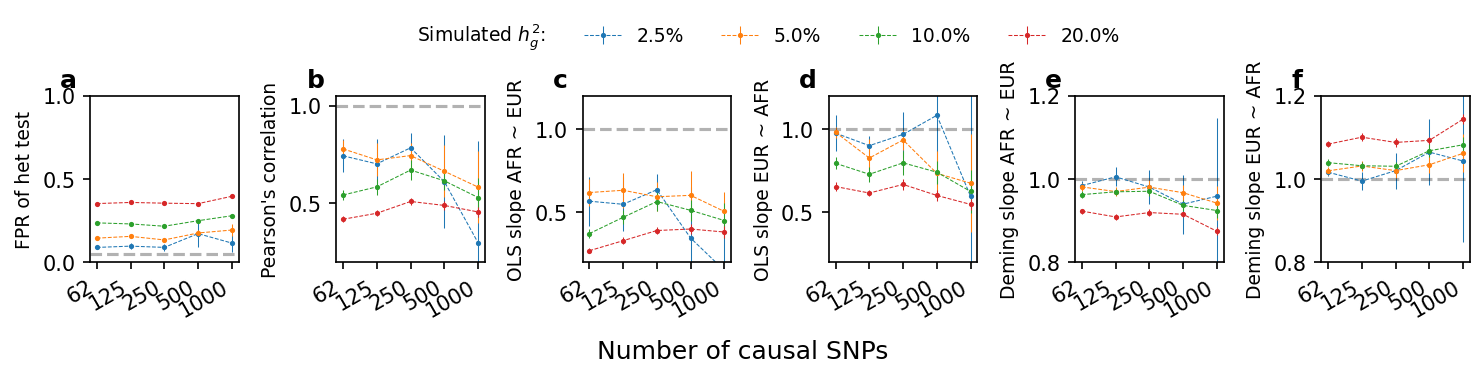

In [10]:
y_var_list = [
    "het_fpr",
    "pearsonr",
    "ols_afr~eur",
    "ols_eur~afr",
    "deming_afr~eur",
    "deming_eur~afr",
]
y_label_list = [
    "FPR of het test",
    "Pearson's correlation",
    "OLS slope AFR ~ EUR",
    "OLS slope EUR ~ AFR",
    "Deming slope AFR ~ EUR",
    "Deming slope EUR ~ AFR",
]
dict_ylim = {
    "het_fpr": [0, 1.0],
    "pearsonr": [0.2, 1.05],
    "ols_afr~eur": [0.2, 1.2],
    "ols_eur~afr": [0.2, 1.2],
    "deming_afr~eur": [0.8, 1.2],
    "deming_eur~afr": [0.8, 1.2],
}
dict_hline = {
    "het_fpr": 0.05,
    "pearsonr": 1.0,
    "ols_afr~eur": 1.0,
    "ols_eur~afr": 1.0,
    "deming_afr~eur": 1.0,
    "deming_eur~afr": 1.0,
}
# "Pearson's correlation" is not plotted because i don't think it makes sense

fig, axes = plt.subplots(figsize=(10, 2), ncols=len(y_var_list), nrows=1, dpi=150)
axes = axes.flatten()

# for each panel
for i, (y_var, y_label) in enumerate(zip(y_var_list, y_label_list)):
    ax = axes[i]
    for hsq in df_plot.hsq.unique():
        df_est_tmp = df_plot[df_plot.hsq == hsq]
        df_se_tmp = df_plot_se[df_plot_se.hsq == hsq]
        ax.errorbar(
            np.arange(len(df_est_tmp.ncausal)),
            df_est_tmp[y_var],
            yerr=df_se_tmp[y_var] * 1.96,
            fmt=".--",
            ms=3,
            mew=1,
            label=f"{hsq * 100}%",
            linewidth=0.5,
        )

    ax.axhline(y=dict_hline[y_var], color="black", ls="--", alpha=0.3)
    ax.set_xticks(np.arange(len(df_est_tmp.ncausal)))
    ax.set_xticklabels(df_est_tmp.ncausal, rotation=30, ha="right")
    ax.set_ylabel(y_label, fontsize=9)
    ax.set_ylim(dict_ylim[y_var])

    # annotation
    ax.text(
        -0.2,
        1.05,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=5,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.05,
    "Number of causal SNPs",
    fontsize=12,
    ha="center",
)


plt.tight_layout()
plt.show()

# Main figure

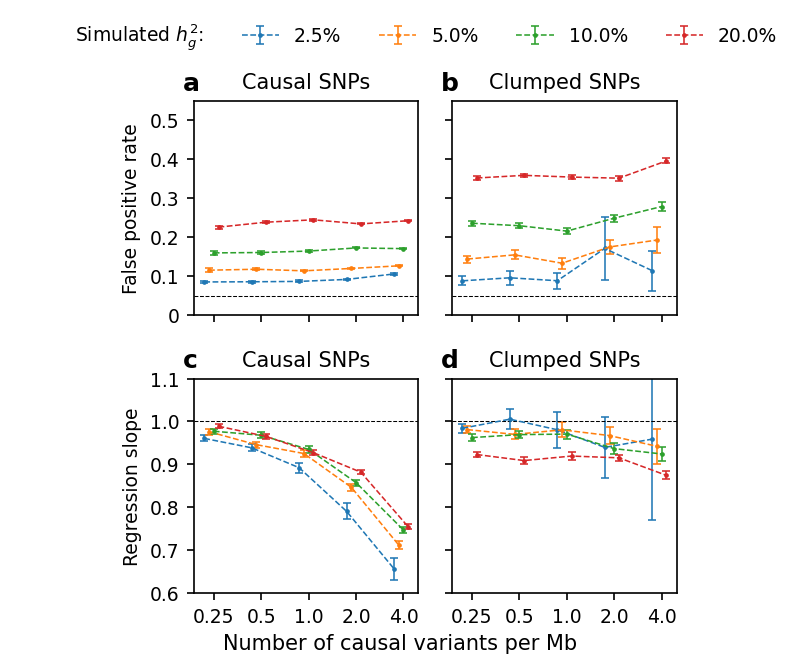

In [11]:
yvar_list = [
    "het_fpr",
    "deming_afr~eur",
]
dict_ylabel = {
    "het_fpr": "False positive rate",
    "deming_afr~eur": "Regression slope",
}
dict_ylim = {
    "het_fpr": [0, 0.55],
    "deming_afr~eur": [0.6, 1.1],
}
dict_yticks = {
    "het_fpr": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "deming_afr~eur": [0.6, 0.7, 0.8, 0.9, 1.0, 1.1],
}
fig, axes = plt.subplots(
    figsize=(4, 4), nrows=2, ncols=2, dpi=150, sharex=True, sharey="row"
)
for group_i, group in enumerate(["causal", "clump"]):
    df_plot, df_plot_se = dict_df_plot[group]
    for yvar_i, yvar in enumerate(yvar_list):
        ax = axes[yvar_i, group_i]
        for hsq_i, hsq in enumerate(df_plot.hsq.unique()):
            df_est_tmp = df_plot[df_plot.hsq == hsq]
            df_se_tmp = df_plot_se[df_plot_se.hsq == hsq]
            ax.errorbar(
                np.arange(len(df_est_tmp.ncausal)) + (hsq_i - 2) * 0.1,
                df_est_tmp[yvar],
                yerr=df_se_tmp[yvar] * 1.96,
                fmt=".--",
                label=f"{hsq * 100}%",
                ms=3,
                linewidth=0.75,
                mew=0.75,
                capsize=2,
            )

        ax.axhline(y=dict_hline[yvar], color="black", ls="--", alpha=1.0, lw=0.5)
        ax.set_xticks(np.arange(len(df_est_tmp.ncausal)))
        ax.set_xticklabels([0.25, 0.5, 1.0, 2.0, 4.0], fontsize=9)
        ax.set_yticks(dict_yticks[yvar])
        ax.set_yticklabels(dict_yticks[yvar], fontsize=9)
        if group_i == 0:
            ax.set_ylabel(dict_ylabel[yvar], fontsize=9)
            ax.set_ylim(dict_ylim[yvar])

        if group == "causal":
            ax.set_title("Causal SNPs", fontsize=10)
        elif group == "clump":
            ax.set_title("Clumped SNPs", fontsize=10)

        # annotation
        ax.text(
            -0.05,
            1.05,
            string.ascii_lowercase[yvar_i * 2 + group_i],
            transform=ax.transAxes,
            size=12,
            weight="bold",
        )

# trick to put title in the same row
handles, labels = axes[0, 0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.0,
    "Number of causal variants per Mb",
    fontsize=10,
    ha="center",
)


plt.tight_layout()
fig.savefig("chrom-simulation.pdf", bbox_inches="tight")
plt.show()